Tic Tac Toe Spielstanderkenner

Ziel dieser Arbeit ist es, dass Bilder eines Tic Tac Toe Spiels eingegeben werden und der Spielstand automatisch erkannt wird. Wenn es einen Gewinner gibt, soll dieser Markiert und ausgegeben werden

Schritt 1 Bilder einlesen

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import color

def show_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def cluster_coords(coords, mindist=20):
    if not coords:
        return []
    coords = sorted(coords)
    clustered = []
    current = [coords[0]]
    for c in coords[1:]:
        if abs(c - current[-1]) < mindist:
            current.append(c)
        else:
            clustered.append(int(np.mean(current)))
            current = [c]
    clustered.append(int(np.mean(current)))
    return clustered

def get_two_most_centered(coords, img_size):
    if len(coords) < 2:
        return None
    targets = [img_size//3, 2*img_size//3]
    selected = []
    coords = sorted(coords)
    for t in targets:
        best = min(coords, key=lambda c: abs(c - t))
        selected.append(best)
        coords.remove(best)
    return sorted(selected)

def get_line_centers(lines, img_size, axis='x'):
    coords = []
    if lines is not None:
        for l in lines:
            x1,y1,x2,y2 = l[0]
            if axis=='x' and abs(x1-x2) < img_size*0.15:
                coords.append((x1+x2)//2)
            if axis=='y' and abs(y1-y2) < img_size*0.15:
                coords.append((y1+y2)//2)
    mind = 15 if axis=='y' else int(img_size*0.04)
    clustered = cluster_coords(coords, mindist=mind)
    print(f"{axis}-ungeclustert:", coords)
    print(f"{axis}-geclustert:", clustered)
    return clustered

def filter_longest_lines(lines, num=12):
    if lines is None or len(lines)==0:
        return []
    segs = [l[0] for l in lines]
    segs.sort(key=lambda l:(l[2]-l[0])**2+(l[3]-l[1])**2, reverse=True)
    return np.array([[s] for s in segs[:num]])

def crop_to_largest_contour(binary, img):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return binary, img
    x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    pad = int(0.04 * max(w,h))
    x,y = max(0,x-pad), max(0,y-pad)
    w,h = min(binary.shape[1]-x, w+2*pad), min(binary.shape[0]-y, h+2*pad)
    return binary[y:y+h, x:x+w], img[y:y+h, x:x+w]

def detect_tic_tac_toe_grid(img_path):
    img_orig = cv2.imread(img_path)
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 7)

    # adaptive threshold
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=51, C=7
    )
    show_image(binary, "Binary Threshold")

    # extract grid mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    grid_only = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    grid_only = cv2.morphologyEx(grid_only, cv2.MORPH_OPEN, kernel)
    show_image(grid_only, "Grid only")

    # detect strong grid lines
    edges_grid = cv2.Canny(grid_only, 20, 70, apertureSize=3)
    h, w = grid_only.shape
    L = int(min(h,w) * 0.5)
    lines = cv2.HoughLinesP(
        edges_grid, 1, np.pi/180,
        threshold=20, minLineLength=L, maxLineGap=20
    )

    # if no lines found, fallback to contour-crop
    if lines is None or len(lines) == 0:
        print("Warnung: Keine Linien gefunden, kontur-basiertes Zuschneiden")
        binary, img_cropped = crop_to_largest_contour(binary, img_orig)
        grid_only = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        grid_only = cv2.morphologyEx(grid_only, cv2.MORPH_OPEN, kernel)
        img = img_cropped
    else:
        # split vertical/horizontal segments
        verts = [l[0] for l in lines if abs(l[0][0] - l[0][2]) < 5]
        hors  = [l[0] for l in lines if abs(l[0][1] - l[0][3]) < 5]

        # get two inner grid coords
        xs = sorted((x1+x2)//2 for x1,y1,x2,y2 in verts)
        ys = sorted((y1+y2)//2 for x1,y1,x2,y2 in hors)
        xs = get_two_most_centered(xs, w)
        ys = get_two_most_centered(ys, h)

        # build boundaries
        x_coords = [0] + xs + [w]
        y_coords = [0] + ys + [h]

        # perform cropping
        x1, x2 = x_coords[0], x_coords[-1]
        y1, y2 = y_coords[0], y_coords[-1]
        img = img_orig[y1:y2, x1:x2]
        binary = binary[y1:y2, x1:x2]
        grid_only = grid_only[y1:y2, x1:x2]

    show_image(grid_only, "Grid only nach Crop")

    # now standard field extraction
    edges = cv2.Canny(grid_only, 20, 70, apertureSize=3)
    show_image(edges, "Edges nach Grid Crop")

    h, w = grid_only.shape
    min_dim = min(h,w)
    minL = int(min_dim*0.1)
    maxG= int(min_dim*0.25)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi/180,
        threshold=10, minLineLength=minL, maxLineGap=maxG
    )
    print("Gefundene Linien (roh):", len(lines) if lines is not None else 0)
    lines = filter_longest_lines(lines, num=12)
    print("Gefundene Linien (gefiltert):", len(lines))

    if lines is not None and len(lines):
        dbg = img.copy()
        for l in lines:
            x1,y1,x2,y2 = l[0]
            cv2.line(dbg, (x1,y1), (x2,y2), (0,255,0), 2)
        show_image(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB), "Alle erkannten Linien")

    x_centers = get_line_centers(lines, w, axis='x')
    y_centers = get_line_centers(lines, h, axis='y')
    vx = get_two_most_centered(x_centers, w)
    hy = get_two_most_centered(y_centers, h)

    x_coords = [0] + vx + [w]
    y_coords = [0] + hy + [h]

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grid = img_rgb.copy()
    field_bilder, positionen = [], []

    for row in range(3):
        for col in range(3):
            xa, xb = x_coords[col], x_coords[col+1]
            ya, yb = y_coords[row], y_coords[row+1]
            feld = img[ya:yb, xa:xb]
            field_bilder.append(feld)
            positionen.append((row, col))
            cv2.rectangle(img_grid, (xa,ya), (xb,yb), (255,0,0), 2)
            cv2.putText(img_grid, f"{row},{col}", (xa+5, ya+25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    show_image(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB), "Gefundene 9 Felder")
    return field_bilder, positionen

def crop_and_resize_field(field_img, size=96, pad_color=(255,255,255)):
    h,w = field_img.shape[:2]
    scale = size / max(h,w)
    nh,nw = int(h*scale), int(w*scale)
    resized = cv2.resize(field_img, (nw,nh), interpolation=cv2.INTER_AREA)
    canvas = np.full((size,size,3), pad_color, dtype=np.uint8)
    ys, xs = (size-nh)//2, (size-nw)//2
    canvas[ys:ys+nh, xs:xs+nw] = resized
    return canvas

def show_9_fields(field_bilder, positionen, size=96):
    fig, axs = plt.subplots(3,3, figsize=(8,8))
    for img_cell,(r,c) in zip(field_bilder, positionen):
        norm = crop_and_resize_field(img_cell, size)
        axs[r,c].imshow(cv2.cvtColor(norm, cv2.COLOR_BGR2RGB))
        axs[r,c].axis('off')
    plt.tight_layout()
    plt.show()

# Beispiel-Aufruf
field_bilder, positionen = detect_tic_tac_toe_grid('noisy_2.png')
show_9_fields(field_bilder, positionen)


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


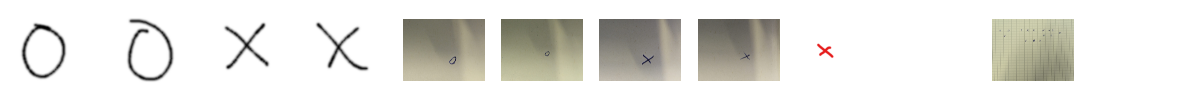

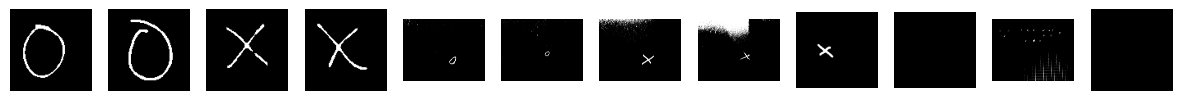

Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 84
Testcase ./Pictures/01.png: O
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 78
Testcase ./Pictures/02.png: O
Valid X detected. Clusters: [np.float64(40.21739130434784), np.float64(132.25)], std devs: [np.float64(4.960334155461447), np.float64(4.8584119490494695)]
Line Score: True, Circle Score: 46
Testcase ./Pictures/x1.png: X
Valid X detected. Clusters: [np.float64(32.1111111111111), np.float64(137.42857142857142)], std devs: [np.float64(4.229391812310704), np.float64(5.043024763515652)]
Line Score: True, Circle Score: 43
Testcase ./Pictures/x2.png: X
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 4675
Testcase ./Pictures/O_1.png: O
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 1282
Testcase ./Pictures/O_2.png: O
Image is messy: 3 clusters explain better than 2

KeyboardInterrupt: 

: 

Schritt zwei Processing Pipeline je Bild

Schleife für alle Bilder

Mögliche Vorschläge:

4. Empfehlungen
Modularisieren: Packt jede Funktion in ein eigenes Modul (preprocess.py, grid.py, warp.py, recognition.py), dann importiert ihr sie in main.py.

Parameter-Tuning: Führt Tests mit verschiedenen sigma, min_size und Hough-Schwellen durch und protokolliert, was am besten funktioniert.

Fehlerbehandlung: Wenn find_grid mal nicht genügend Linien findet, überspringt das Bild oder versucht einen alternativen Ansatz (z. B. Kanten-Dilatation).

Batch-Logging: Schreibt in eine Log-Datei, welche Bilder erfolgreich geprocessed wurden und welche fehlschlugen.